In [ ]:
import requests, zipfile, io
import cv2
import glob
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import os 
from dask import bag, diagnostics
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
from keras.utils import to_categorical
import albumentations as A
from google.colab import drive,files
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

**Importing Data files**

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!wget https://zenodo.org/record/4628934/files/ncd.zip?download=1

--2023-01-28 11:24:56--  https://zenodo.org/record/4628934/files/ncd.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353537126 (337M) [application/octet-stream]
Saving to: ‘ncd.zip?download=1’

ncd.zip?download=1  100%[===================>] 337.16M  12.5MB/s    in 30s     

2023-01-28 11:25:28 (11.4 MB/s) - ‘ncd.zip?download=1’ saved [353537126/353537126]



In [ ]:
!unzip /content/ncd.zip?download=1

Archive:  /content/ncd.zip?download=1
   creating: ncd/
  inflating: ncd/ncd.234.jpg         
  inflating: ncd/ncd.346.jpg         
  inflating: ncd/ncd.33.jpg          
  inflating: ncd/ncd.371.jpg         
  inflating: ncd/ncd.45.jpg          
  inflating: ncd/ncd.48.jpg          
  inflating: ncd/ncd.369.jpg         
  inflating: ncd/ncd.297.jpg         
  inflating: ncd/ncd.135.jpg         
  inflating: ncd/ncd.292.jpg         
  inflating: ncd/ncd.173.jpg         
  inflating: ncd/ncd.14.jpg          
  inflating: ncd/ncd.246.jpg         
  inflating: ncd/ncd.209.jpg         
  inflating: ncd/ncd.368.jpg         
  inflating: ncd/ncd.176.jpg         
  inflating: ncd/ncd.204.jpg         
  inflating: ncd/ncd.156.jpg         
  inflating: ncd/ncd.73.jpg          
  inflating: ncd/ncd.23.jpg          
  inflating: ncd/ncd.119.jpg         
  inflating: ncd/ncd.165.jpg         
  inflating: ncd/ncd.28.jpg          
  inflating: ncd/ncd.22.jpg          
  inflating: ncd/ncd.244.jpg    

In [ ]:
os.mkdir('gdrive/MyDrive/data/Resized-ncd')

In [ ]:
def resize(folder,save_to):
  i= 0
  images = glob.glob(folder + "/*.jpg")
  for img in  images:
    image= Image.open(img)
    image= image.resize((299,299))
    image.save(f"{save_to}/resized{i}.jpg")
    i+=1
  print(f'successfully saved to {save_to}')

In [ ]:
resize('/content/ncd','gdrive/MyDrive/data/Resized-ncd')

successfully saved to gdrive/MyDrive/data/Resized-ncd


Augmentaion of images

In [ ]:
# we need to fix data imbalance (class NCD )
#Using Data Augmentation we can quickly increase the amount of data for our imbalanced classes,
#this will ensure that our model does not see the same image twice and helps avoid overfitting and aids the model to generalise better.
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
cocci = glob.glob('/content/gdrive/MyDrive/data/Resized-cocci/*')[:500]
healthy = glob.glob('/content/gdrive/MyDrive/data/Resized-healthy/*')[:500]
salmo = glob.glob('/content/gdrive/MyDrive/data/Resized-salmo/*')[:500]
ncd = glob.glob('/content/gdrive/MyDrive/data/Resized-ncd/*')[:500]

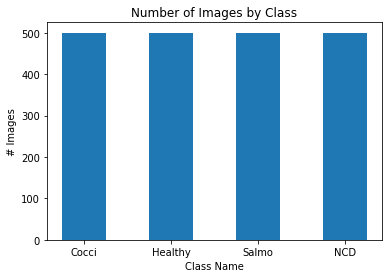

In [ ]:
dict_ = {"Cocci":len(cocci) ,"Healthy":len(healthy),"Salmo":len(salmo),"NCD":len(ncd)}
plt.bar(dict_.keys(), dict_.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.show()

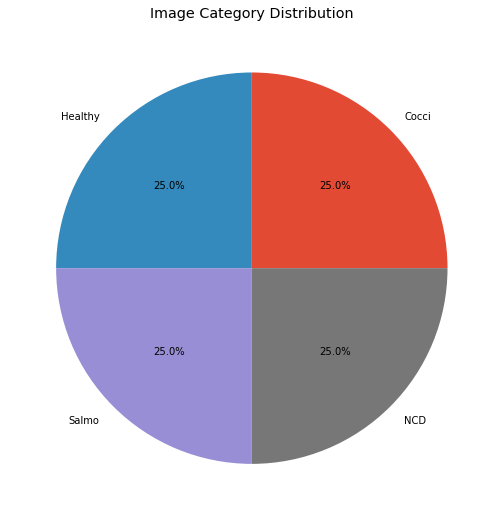

In [ ]:
labels = dict_.keys()
targets = dict_.values()
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

In [ ]:
labels = []
data =[] 

In [ ]:
def prepare_images(array,class_no):
  for img in array:
    x = load_img(img)
    x = img_to_array(x)
    data.append(x)
    labels.append(class_no)

In [ ]:
prepare_images(cocci,0)
prepare_images(healthy,1)
prepare_images(salmo,2)
prepare_images(ncd,3)

In [ ]:
data = np.array(data)
labels = to_categorical(labels)

In [ ]:
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.20, random_state=42,shuffle=True)

In [ ]:
base_model = Xception(weights='imagenet', include_top =False, input_shape=(299, 299, 3), classes=4)

In [ ]:
# freeze the base model 
base_model.trainable = False

In [ ]:
# Add a classification head
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21,124,268
Trainable params: 262,788
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_tl.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),  metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train,ytrain,epochs=100,batch_size=12,validation_data=(X_test, ytest),callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
134/134 [==============================] - 26s 138ms/step - loss: 5.1318 - accuracy: 0.5238 - val_loss: 1.5329 - val_accuracy: 0.6075
Epoch 2/100
134/134 [==============================] - 15s 111ms/step - loss: 1.8862 - accuracy: 0.6025 - val_loss: 1.4296 - val_accuracy: 0.6325
Epoch 3/100
134/134 [==============================] - 15s 109ms/step - loss: 1.0447 - accuracy: 0.6888 - val_loss: 1.2089 - val_accuracy: 0.6300
Epoch 4/100
134/134 [==============================] - 17s 130ms/step - loss: 0.8578 - accuracy: 0.7212 - val_loss: 0.9862 - val_accuracy: 0.6725
Epoch 5/100
134/134 [==============================] - 17s 128ms/step - loss: 0.7754 - accuracy: 0.7437 - val_loss: 1.7104 - val_accuracy: 0.5550
Epoch 6/100
134/134 [==============================] - 15s 115ms/step - loss: 0.8973 - accuracy: 0.7250 - val_loss: 0.9395 - val_accuracy: 0.6900
Epoch 7/100
134/134 [==============================] - 15s 114ms/step - loss: 0.7032 - accuracy: 0.7606 - val_loss: 1.3684 -

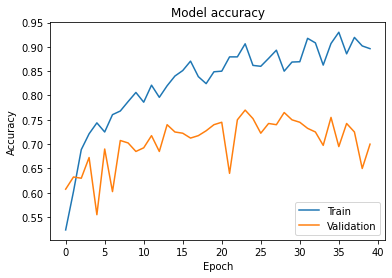

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# load the best model
best_model_tl = keras.models.load_model('best_model_tl.h5')

In [ ]:
# Get predictions
y_pred = best_model_tl.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

13/13 [==============================] - 6s 317ms/step

--- Confusion Matrix ---

[[96  2  1  5]
 [ 5 84  2  4]
 [11  3 52 22]
 [15  9 13 76]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       104
           1       0.86      0.88      0.87        95
           2       0.76      0.59      0.67        88
           3       0.71      0.67      0.69       113

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.76       400
weighted avg       0.77      0.77      0.76       400



In [ ]:
# Unfreeze some layers in the base model
base_model.trainable = True

In [ ]:
# free some memory 
del data 
del labels 
del best_model_tl

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),  metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_fn.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    X_train,ytrain,epochs=100,batch_size=32,validation_data=(X_test, ytest),callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
50/50 [==============================] - 72s 1s/step - loss: 0.8253 - accuracy: 0.7281 - val_loss: 1.1779 - val_accuracy: 0.5800
Epoch 2/100
50/50 [==============================] - 66s 1s/step - loss: 0.0989 - accuracy: 0.9669 - val_loss: 0.2079 - val_accuracy: 0.9250
Epoch 3/100
50/50 [==============================] - 66s 1s/step - loss: 0.0294 - accuracy: 0.9931 - val_loss: 0.1537 - val_accuracy: 0.9400
Epoch 4/100
50/50 [==============================] - 66s 1s/step - loss: 0.0086 - accuracy: 0.9987 - val_loss: 0.0833 - val_accuracy: 0.9775
Epoch 5/100
50/50 [==============================] - 65s 1s/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0942 - val_accuracy: 0.9700
Epoch 6/100
50/50 [==============================] - 65s 1s/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0700 - val_accuracy: 0.9775
Epoch 7/100
50/50 [==============================] - 65s 1s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9750
Epoch 8/100
5

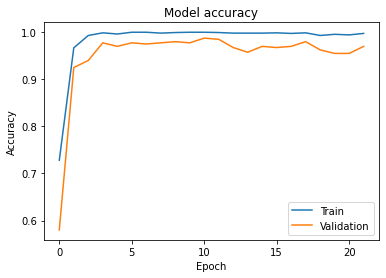

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# load the best model
best_model_fn = keras.models.load_model('best_model_fn.h5')

In [ ]:
# Get predictions
y_pred = best_model_fn.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)